# Baseline model for batch monitoring example

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

/home/tim/.pyenv/versions/3.9.7/envs/monitoring/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tim/.pyenv/versions/3.9.7/envs/monitoring/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tim/.pyenv/versions/3.9.7/envs/monitorin

In [ ]:
files = [('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

In [31]:
march_data = pd.read_parquet('../data/green_tripdata_2023-03.parquet')

In [32]:
march_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,72044.000000,72044,72044,67507.000000,72044.000000,72044.000000,67507.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,0.0,72044.000000,72044.000000,67507.000000,67500.000000,67507.000000
mean,1.865443,2023-03-16 08:02:42.689842432,2023-03-16 08:20:56.525747968,1.145703,98.437413,137.613556,1.286844,12.449511,17.018203,0.878109,0.576929,2.157651,0.183268,NaN,0.961604,22.292310,1.373680,1.028681,0.714837
min,1.000000,2023-02-23 16:46:29,2023-02-23 16:55:25,1.000000,1.000000,1.000000,0.000000,0.000000,-115.000000,-5.000000,-0.500000,-1.100000,0.000000,NaN,-1.000000,-116.000000,1.000000,1.000000,-2.750000
25%,2.000000,2023-03-08 13:55:49.500000,2023-03-08 14:15:59.750000128,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.980000,1.000000,1.000000,0.000000
50%,2.000000,2023-03-16 08:05:27.500000,2023-03-16 08:22:27,1.000000,75.000000,138.000000,1.000000,1.840000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,18.100000,1.000000,1.000000,0.000000
75%,2.000000,2023-03-23 21:51:25.500000,2023-03-23 22:12:31.500000,1.000000,129.000000,216.000000,1.000000,3.300000,20.000000,1.000000,0.500000,3.360000,0.000000,NaN,1.000000,26.730000,2.000000,1.000000,2.750000
max,2.000000,2023-04-01 00:09:27,2023-04-01 17:32:21,99.000000,265.000000,265.000000,9.000000,92064.680000,477.000000,12.500000,4.250000,270.270000,36.050000,NaN,1.000000,478.000000,5.000000,2.000000,2.750000
std,0.341252,NaN,NaN,1.225735,60.481870,76.169705,0.923652,641.094653,13.832399,1.297642,0.384129,3.136215,1.139159,NaN,0.185185,15.852047,0.512307,0.166911,1.206435


# Q1. Prepare the dataset

In [33]:
march_data.shape

(72044, 20)

In [34]:
# create target
march_data["duration_min"] = march_data.lpep_dropoff_datetime - march_data.lpep_pickup_datetime
march_data.duration_min = march_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [35]:
# filter out outliers
march_data = march_data[(march_data.duration_min >= 0) & (march_data.duration_min <= 60)]
march_data = march_data[(march_data.passenger_count > 0) & (march_data.passenger_count <= 8)]

<Axes: >

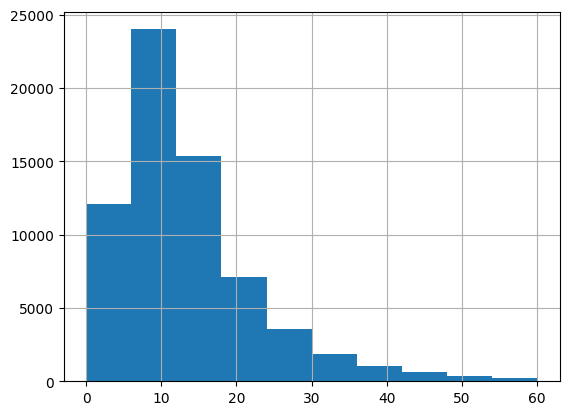

In [36]:
march_data.duration_min.hist()

In [37]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [38]:
march_data.shape

(66255, 21)

In [39]:
train_data = march_data[:30000]
val_data = march_data[30000:]

In [40]:
model = LinearRegression()

In [41]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [42]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [43]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [44]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.5641759571064924
3.646951695051199


# Dump model and reference data

In [45]:
with open('./lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [46]:
val_data.to_parquet('./reference.parquet')

# Evidently Report

In [47]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [48]:
from evidently.metrics import ColumnQuantileMetric

# Q2. Metric

In [49]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
]
)

In [50]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [51]:
report.show(mode='inline')

In [52]:
result = report.as_dict()

In [53]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.02191274473735342,
    'drift_detected': False,
    'current': {'small_distribution': {'x': [-29.97693868706996,
       -6.360433663687505,
       17.25607135969495,
       40.8725763830774,
       64.48908140645986,
       88.10558642984232,
       111.72209145322476,
       135.33859647660722,
       158.95510149998967,
       182.5716065233721,
       206.1881115467546],
      'y': [9.343432451141222e-06,
       0.0344305485824554,
       0.007515623477886722,
       0.00034570700069222514,
       2.335858112785305e-05,
       8.175503394748573e-06,
       5.839645281963262e-06,
       1.1679290563926532e-06,
       2.3358581127853063e-06,
       1.1679290563926504e-06]}},
    'reference': {'small_distribution': {'x': [-44.79458026994594,
       -20.705700872911216,


In [54]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.02191274473735342

In [55]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [56]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

0.0454570529456752

In [57]:
result['metrics'][3]['result']['current']['value']

12.8

# Q3. Prefect flow

@task(retries=2, retry_delay_seconds=5, name="calculate metrics") <-correct

# Q4. Monitoring

In [63]:
!python evidently_metrics_calculation.py

/home/tim/.pyenv/versions/monitoring/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tim/.pyenv/versions/monitoring/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tim/.pyenv/versions/monitoring/lib/python3.9/site-packages/uma

22:27:19.245 | INFO    | Flow run 'loyal-ape' - Created task run 'calculate metrics-14' for task 'calculate metrics'
22:27:19.247 | INFO    | Flow run 'loyal-ape' - Executing 'calculate metrics-14' immediately...
14 0.5718006350850434 4 0.06934131294100263 13.5
22:27:24.877 | INFO    | Task run 'calculate metrics-14' - Finished in state Completed()
22:27:29.350 | INFO    | Flow run 'loyal-ape' - Created task run 'calculate metrics-15' for task 'calculate metrics'
22:27:29.351 | INFO    | Flow run 'loyal-ape' - Executing 'calculate metrics-15' immediately...
15 0.5436944138823782 4 0.06773077946262304 13.5
22:27:34.804 | INFO    | Task run 'calculate metrics-15' - Finished in state Completed()
22:27:39.295 | INFO    | Flow run 'loyal-ape' - Created task run 'calculate metrics-16' for task 'calculate metrics'
22:27:39.297 | INFO    | Flow run 'loyal-ape' - Executing 'calculate metrics-16' immediately...
16 2.987288992528056 5 0.06528650914083388 13.5
22:27:44.857 | INFO    | Task run 'ca